# Exercise Flextopo 

In this exercise you are asked to create a Flextopo model in a seperate Python file which will be imported here. This notebook can then be used to run the model, the notebook also imports the relevant packages needed to run it on eWaterCycle.

Here you will need to change a few functions that will be in the cells below.

Once you have added your code, save the file and run the notebook below. Read carefully, you will have to change some things yourself. The first part will create a hydrograph in which you can compare your calculated discharge with the reference discharge. In the second part, a test case is created which will check your model with a pre-defined parameter set and initial storages. Optionally, in the third part you can create a test case yourself.

Important: Anytime you edit the code in hbv_bmi.py, it is important to restart the kernel and re-run the cells, to make sure your changes are imported (in cell 3 below)

In [1]:
# General python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# from FLEXtopo import FLEXtopo
from datetime import datetime
from Weigfun import Weigfun
from plateau import plateau_func
import warnings
warnings.filterwarnings('ignore')


## Building Flextopo model

First we need to build our model, you do this by coding in the following cells.
We will start with the hillslope and wetland function. After that you can finalize the flextopo function. **NOTE** this is not written in BMI (yet).

### Hillslope

In [2]:
def hillslope_func(timestep, Par, forcing, Fluxes, States):
	# HBVpareto Calculates values of 3 objective functions for HBV model

	I_max = Par[0]
	Ce = Par[1]
	Su_max = Par[2]
	beta = Par[3]
	D = Par[4]
	Kf = Par[5]
	Qo = forcing['Qo']
	Prec = forcing['Prec']
	Etp = forcing['Etp']


	t_max = len(Prec)
	Si = States[:,0]
	Su = States[:,1]
	Sf = States[:,2]

	Ei_dt = Fluxes[:,0]
	Ea_dt = Fluxes[:,1]
	Qf_dt = Fluxes[:,2]
	Qusdt = Fluxes[:,3]

	dt = 1
	t = timestep


	P_dt = Prec[t] * dt
	Ep_dt = Etp[t] * dt
	# Interception Reservoir
	if P_dt > 0:
		Si[t] = Si[t] + P_dt
		Pe_dt = max(0, Si[t]-I_max)
		Si[t] = Si[t] - Pe_dt
		Ei_dt[t] = 0
	else:
	# Evaporation only when there is no rainfall
		Pe_dt = 0
		Ei_dt[t] =min(Ep_dt, Si[t])
		Si[t] = Si[t] - Ei_dt[t]

	if t < t_max - 1:
		Si[t+1] = Si[t]


	# Unsaturated Reservoir
	if Pe_dt > 0:
		rho = (Su[t]/Su_max) ** beta
		Su[t] = Su[t] + (1-rho) * Pe_dt
		Quf_dt = rho * Pe_dt
	else:
		Quf_dt = 0

	# Transpiration
	Ep_dt = max(0, Ep_dt-Ei_dt[t])
	Ea_dt[t] = Ep_dt * (Su[t]/(Su_max*Ce))
	Ea_dt[t] = min(Ea_dt[t], Su[t])
	Su[t] = Su[t] - Ea_dt[t]
	if t < t_max -1:
		Su[t+1] = Su[t]

	# Preferential Percolation
	Qusdt = D * Quf_dt

	# Fast Reservoir
	Sf[t] = Sf[t] + (1-D) * Quf_dt
	Qf_dt[t] = dt * Kf * Sf[t]
	Sf[t] = Sf[t] - min(Qf_dt[t], Sf[t])
	if t < t_max - 1:
		Sf[t+1] = Sf[t]


	# Save output
	States[:,0] = Si
	States[:,1] = Su
	States[:,2] = Sf

	Fluxes[:,0] = Ei_dt
	Fluxes[:,1] = Ea_dt
	Fluxes[:,2] = Qf_dt
	Fluxes[:,3] = Qusdt

	return(Fluxes, States)

### Wetlands

In [3]:
def wetland_func(timestep, Par, forcing, Fluxes, States, Ss, landscape_per):
	# HBVpareto Calculates values of 3 objective functions for HBV model

	I_max = Par[0]
	Ce = Par[1]
	Su_max = Par[2]
	beta = Par[3]
	C_max = Par[4]
	Kf = Par[5]

	Qo = forcing['Qo']
	Prec = forcing['Prec']
	Etp = forcing['Etp']


	t_max = len(Prec)
	Si = States[:,0]
	Su = States[:,1]
	Sf = States[:,2]

	Ei_dt = Fluxes[:,0]
	Ea_dt = Fluxes[:,1]
	Qf_dt = Fluxes[:,2]

	dt = 1
	t = timestep


	P_dt = Prec[t] * dt
	Ep_dt = Etp[t] * dt
	# Interception Reservoir
	if P_dt > 0:
		Si[t] = Si[t] + P_dt
		Pe_dt = max(0, Si[t]-I_max)
		Si[t] = Si[t] - Pe_dt
		Ei_dt[t] = 0
	else:
	# Evaporation only when there is no rainfall
		Pe_dt = 0
		Ei_dt[t] = min(Ep_dt, Si[t])
		Si[t] = Si[t] - Ei_dt[t]

	if t < t_max - 1:
		Si[t+1] = Si[t]


	# Unsaturated Reservoir
	if Pe_dt > 0:
		rho = (Su[t]/Su_max) ** beta
		Su[t] = Su[t] + (1-rho) * Pe_dt
		Quf_dt = rho * Pe_dt
	else:
		Quf_dt = 0

	# Transpiration
	Ep_dt = max(0, Ep_dt-Ei_dt[t])
	Ea_dt[t] = Ep_dt * (Su[t]/(Su_max*Ce))
	Ea_dt[t] = min(Ea_dt[t], Su[t])
	Su[t] = Su[t] - Ea_dt[t]

	# Capillary rise
	Qr_dt = (1-Su[t]/Su_max) * C_max * dt
	Qr_dt = min(Qr_dt, Ss[t]/landscape_per)

	if ((Su[t] + Qr_dt) > Su_max):
		Qr_dt = Su_max - Su[t]

	Su[t] = Su[t] + Qr_dt
	Ss[t] = Ss[t] - Qr_dt * landscape_per

	if t < t_max - 1:
		Su[t+1] = Su[t]


	# Fast Reservoir
	Sf[t] = Sf[t] + Quf_dt
	Qf_dt[t] = dt * Kf * Sf[t]
	Sf[t] = Sf[t]- min(Qf_dt[t], Sf[t])
	if t < t_max-1:
		Sf[t+1] = Sf[t]


	# Save output
	States[:,0] = Si
	States[:,1] = Su
	States[:,2] = Sf

	Fluxes[:,0] = Ei_dt
	Fluxes[:,1] = Ea_dt
	Fluxes[:,2] = Qf_dt

	return(Fluxes, States, Ss)

### Flextopo

In [4]:
def FLEXtopo(ParPlateau, ParHillslope, ParWetland, ParCatchment, forcing, landscapes):


	# Parameters and constants
	T_lag = ParCatchment[1]
	Ks = ParCatchment[0]
	dt = 1
	t_max = len(forcing['Qo'])

	# Initialize states
	States_plateau = np.zeros((t_max,3))
	States_hillslope = np.zeros((t_max,3))
	States_wetland = np.zeros((t_max,3))
	Ss = np.zeros((t_max,1))

	# Initialize fluxes
	Fluxes_plateau = np.zeros((t_max,4))
	Fluxes_hillslope = np.zeros((t_max,4))
	Fluxes_wetland = np.zeros((t_max,3))
	Qsdt = np.zeros(t_max)
	Qtotdt = np.zeros(t_max)

	# Loop over time
	for t in range(0,t_max):

		# Plateau
		Fluxes_plateau, States_plateau = plateau_func(t, ParPlateau, forcing, Fluxes_plateau, States_plateau)
		# Hillslope
		Fluxes_hillslope, States_hillslope = hillslope_func(t, ParHillslope, forcing, Fluxes_hillslope, States_hillslope)

		# Petland
		Fluxes_wetland, States_wetland, Ss = wetland_func(t, ParWetland, forcing, Fluxes_wetland, States_wetland, Ss, landscapes[2])

		# Slow Reservoir
		Ss[t] = Ss[t] + Fluxes_plateau[t,3] * landscapes[0] + Fluxes_hillslope[t,3] * landscapes[1]
		Qsdt = dt * Ks * Ss[t]
		Ss[t] = Ss[t] - min(Qsdt,Ss[t])
		if t < t_max - 1:
			Ss[t+1] = Ss[t]

		Qtotdt[t] = Qsdt + Fluxes_plateau[t,2] * landscapes[0] + Fluxes_hillslope[t,2] * landscapes[1] +  Fluxes_wetland[t,2] * landscapes[2]




	# Offset Q

	Weigths = Weigfun(T_lag)

	Qm = np.convolve(Qtotdt, Weigths)
	Qm = Qm[0:t_max]

	return(Qm)




## Landscapes

In the folder `wark_data` you can find data from the Wark region. In the cell below the data is loaded into arrays and plotted. 

In [5]:
DEM = np.genfromtxt('dem.asc',  dtype=float, autostrip=True)
slope = np.genfromtxt('slope.asc',  dtype=float, autostrip=True)
hand = np.genfromtxt('HAND.asc',  dtype=float, autostrip=True)
basin = np.genfromtxt('basin.asc',  dtype=float, autostrip=True)

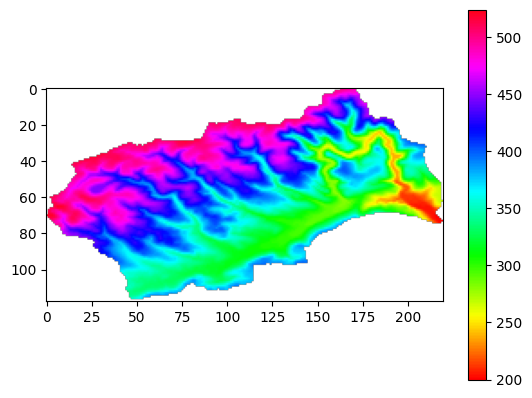

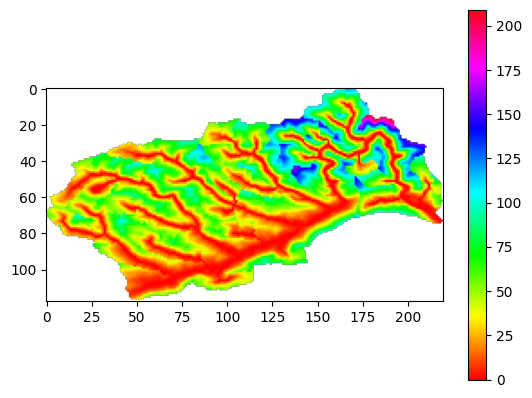

In [6]:
# plot DEM
plt.figure(1)
DEM[DEM==-9999]=np.nan
plt.imshow(DEM, cmap='hsv')
plt.colorbar()

'''UPDATE'''
# plot HAND
plt.figure(2)
hand[hand==-9999]=np.nan
plt.imshow(hand, cmap='hsv')
plt.colorbar()

## Classification

Make a landscape classification for the Wark catchment. Use the HRU classification matrix ( see lecture slides “Models Lecture 4”). Set the HAND threshold to 5m and the slope threshold to 11%.

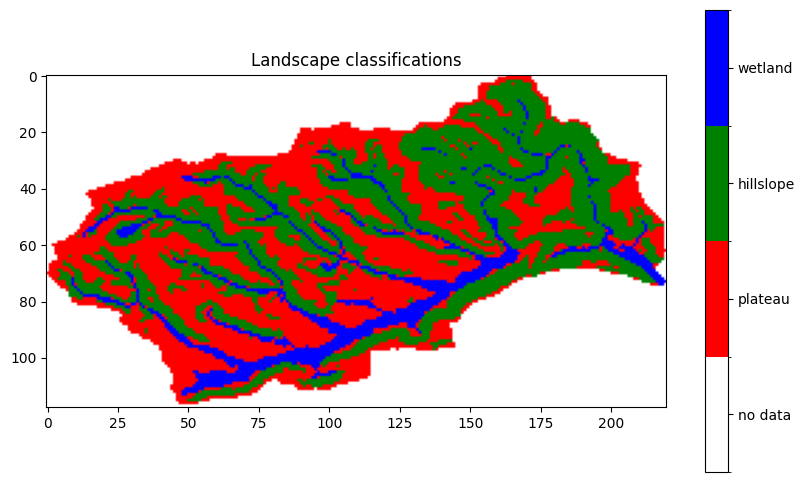

In [7]:
# Make landscape classification
hillslope = np.array(slope) >11
plateau = (np.array(hand) > 5) & (np.array(slope) <= 11)
wetland = (np.array(hand) <= 5) & (np.array(slope) <= 11)
basin = np.array(basin) > 0

hillslope_per = float(np.sum(hillslope))/float(np.sum(basin))
wetland_per = float(np.sum(wetland))/float(np.sum(basin))
plateau_per = float(np.sum(plateau))/float(np.sum(basin))

landscapes = np.zeros((118,220))
landscapes[plateau] = 1
landscapes[hillslope] = 2
landscapes[wetland] = 3

# Plot landscapes
cmap = mpl.colors.ListedColormap(['white', 'red', 'green', 'blue'])
bounds = [0,1,2,3,4]
labels = ['no data', 'plateau', 'hillslope', 'wetland']
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Landscape classifications')
im = ax.imshow(landscapes, cmap=cmap, norm=norm,)
# Create color bar
cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.set_ticklabels(labels)
plt.show()

## Run Model

Load the forcing data from the text file in the `wark_data` folder. 
Define the parameters as you did before for the HBV model, now you need to define them for `Plateau`, `Hillslope` and `Wetland` areas. `Ks` and `T_lag` are defined for the whole catchment. 

In [8]:
# Assuming the text file has three columns: year, month, day
# Use pandas to read the text file
df = pd.read_csv('forcingWark.txt', sep='\s+', header=None, names=['month', 'day', 'year', 'Qo', 'Prec', 'Etp'], dtype=float)

# Create a new column that combines the year, month, and day into a datetime object
df['date'] = pd.to_datetime(df[['day', 'month', 'year']])

forcing = df

In [9]:
#      I_max Ce Su_max beta Pmax    Kf
ParPlateau   = np.array([3.2, 0.50, 17.40, 0.95, 1.76, 0.91])
                  #      I_max Ce Su_max beta D     Kf
ParHillslope = np.array([3.25, 0.50, 321.99, 0.99, 0.4, 0.97])
                  #      I_max Ce Su_max beta C_max     Kf
ParWetland   = np.array([9.94, 0.50, 53.25, 0.70, 0.65, 0.45])
              # Ks T_lag
ParCatchment = np.array([0.0281, 2.21])

'''UPDATE'''
# Landscape percentages
landscape_per = np.array([plateau_per, hillslope_per, wetland_per])

## Calculate the discharge 

Use the FLEXtopo model to calculate the discharge. Plot it together with the measured discharge.

Text(0, 0.5, 'Flow')

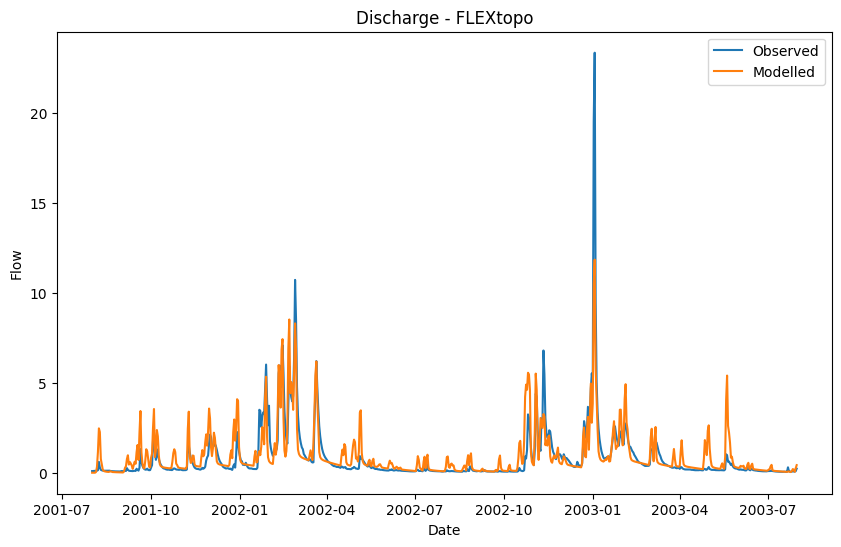

In [10]:
Qm = FLEXtopo(ParPlateau, ParHillslope, ParWetland, ParCatchment, forcing, landscape_per)
Qo = forcing['Qo']	

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['date'], Qo, label='Observed')
ax.plot(df['date'], Qm, label='Modelled')
ax.legend()
ax.set_title('Discharge - FLEXtopo')

ax.set_xlabel('Date')
ax.set_ylabel('Flow')